# Newt Segmentation
> This notebook is used to segment the newts in the Barhill dataset using the Grounded-SAM-2 model.

---
skip_showdoc: true
---

In [25]:
#|default_exp segmentation

In [26]:
#| eval: false
import os
import pathlib

data_path = pathlib.Path("./data/barhill-newts-all")

if not data_path.exists():
    os.system(f"kaggle datasets download -d mshahoyi/barhill-newts-all --unzip -p {data_path}")

In [27]:
#| eval: false
try:
    import supervision
    os.chdir("gsam2")
except:
    os.system('git clone https://github.com/IDEA-Research/Grounded-SAM-2 gsam2')
    os.chdir("gsam2")
    os.system('pip install -q -e . -e grounding_dino')
    os.system('pip install -q supervision')

/kaggle/working/gcn-reid/nbs/gsam2


In [ ]:
#|eval: false
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycocotools.mask as mask_util
from PIL import Image
import argparse
import os
import cv2
import json
import torch
import pandas as pd
from gcn_reid.newt_dataset import upload_to_kaggle
import pathlib
import shutil
from datetime import datetime
import subprocess
import tempfile
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import supervision as sv
import pycocotools.mask as mask_util
from pathlib import Path
from supervision.draw.color import ColorPalette
from utils.supervision_utils import CUSTOM_COLOR_MAP
from PIL import Image
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import pandas as pd

In [29]:
GROUNDING_MODEL = "IDEA-Research/grounding-dino-base"
SAM2_CHECKPOINT = "./checkpoints/sam2.1_hiera_large.pt"
SAM2_MODEL_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_DIR = Path("outputs/test_sam2.1")
DUMP_JSON_RESULTS = True
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
TEXT_PROMPT = "newt amphibian reptile."


torch.autocast(device_type=DEVICE, dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

os.chdir("checkpoints")
os.system("bash download_ckpts.sh")
os.chdir("..")

sam2_checkpoint = SAM2_CHECKPOINT
model_cfg = SAM2_MODEL_CONFIG
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=DEVICE)
sam2_predictor = SAM2ImagePredictor(sam2_model)

model_id = GROUNDING_MODEL
processor = AutoProcessor.from_pretrained(model_id)
grounding_model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(DEVICE)

os.chdir("..")

In [30]:
df = pd.read_csv(data_path / "metadata.csv")
df

# Create Boudning Boxes

df['bbox'] = None

for i, row in tqdm(df[~df.is_video].iterrows()):  # Process first 3 newts for demo
    image_path = data_path / row.file_path
    image_key = f"{row.identity}/{row.file_name}"
    image = cv2.imread(image_path)
    pil_image = Image.open(image_path)
    inputs = processor(images=pil_image, text=TEXT_PROMPT, return_tensors="pt").to(DEVICE)
    with torch.no_grad(): 
        outputs = grounding_model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.4,
        text_threshold=0.3,
        target_sizes=[(image.shape[0], image.shape[1])]
    )[0]  # Get first (and only) result
    
    bbox = results["boxes"].cpu().numpy().tolist()
    if len(bbox) > 0:
        df.at[i, 'bbox'] = bbox[0]
    else:
        df.at[i, 'bbox'] = None

In [ ]:
df.bbox.describe()

# Add manual annotations

In [ ]:
with open("manual_annotations.json", "r") as f:
    manual_annotations = json.load(f)

In [ ]:
for annot in manual_annotations["images"]:
    image_name = annot["image"]
    bbox_dict = annot["annotations"][0]["boundingBox"]
    # Convert from XYWH to XYXY format
    x, y, w, h = bbox_dict["x"], bbox_dict["y"], bbox_dict["width"], bbox_dict["height"]
    bbox = [x, y, x + w, y + h]  # Convert to XYXY format
    df.at[df[df.file_name == image_name].index[0], "bbox"] = bbox

In [ ]:
df.bbox.describe()

# Visualise bounding boxes

In [ ]:
#| export
def visualize_bbox(image_path, bbox, label):
    import cv2
    import numpy as np
    import supervision as sv
    from utils.supervision_utils import CUSTOM_COLOR_MAP
    import matplotlib.pyplot as plt
    
    img = cv2.imread(image_path)
    detections = sv.Detections(
        xyxy=np.array(bbox).reshape(1, 4),
        mask=None,  # (n, h, w)
        class_id=np.array([0])
    )


    box_annotator = sv.BoxAnnotator(color=sv.ColorPalette.from_hex(CUSTOM_COLOR_MAP))
    annotated_frame_boxes = box_annotator.annotate(scene=img.copy(), detections=detections)
    label_annotator = sv.LabelAnnotator(color=sv.ColorPalette.from_hex(CUSTOM_COLOR_MAP), text_color=sv.Color.BLACK) # Specify text color if needed
    annotated_frame_labels = label_annotator.annotate(scene=annotated_frame_boxes.copy(), detections=detections, labels=[label])

    plt.imshow(cv2.cvtColor(annotated_frame_labels, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
i = df[df.bbox.notna()].index[0]
visualize_bbox(data_path / df.iloc[i].file_path, df.iloc[i].bbox, "newt")

# Create Segmentation Masks

In [ ]:
df['segmentation_mask_rle'] = None

for i, row in tqdm(df[~df.is_video].iterrows()):
    image_path = data_path / row.file_path
    # image = cv2.imread(image_path)
    pil_image = Image.open(image_path)
    
    box = np.array(row.bbox).reshape(1, 4)
    sam_box = box.astype(int)
    sam2_predictor.set_image(np.array(pil_image.convert("RGB")))
    masks, _, _ = sam2_predictor.predict(
        box=sam_box,
        multimask_output=False
    )
    mask = masks[0]  # Get the first (and only) mask
    mask_uint8 = mask.astype(np.uint8, order='F')
    rle = mask_util.encode(mask_uint8)
    rle_string = rle['counts'].decode('utf-8') if isinstance(rle['counts'], bytes) else str(rle['counts'])

    df.at[i, 'segmentation_mask_rle'] = f"{rle['size'][0]}x{rle['size'][1]}:{rle_string}"

In [ ]:
df.segmentation_mask_rle.describe()

# Visualise Segmentation Masks

In [ ]:
#| export
def decode_rle_mask(rle_string):
    """Decode RLE string back to binary mask"""
    import pandas as pd
    import pycocotools.mask as mask_util
    
    parts = rle_string.split(':', 1)
    if len(parts) != 2:
        print(f"Invalid RLE format: {rle_string[:100]}...")
        return None
        
    size_part, counts_part = parts
    height, width = map(int, size_part.split('x'))
    
    rle_dict = {
        'size': [height, width],
        'counts': counts_part.encode('utf-8')
    }
    
    mask = mask_util.decode(rle_dict)
    return mask

In [ ]:
i = df[df.segmentation_mask_rle.notna()].index[0]
mask = decode_rle_mask(df.iloc[i].segmentation_mask_rle)
plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(data_path / df.iloc[i].file_path))
plt.axis('off')
plt.show()

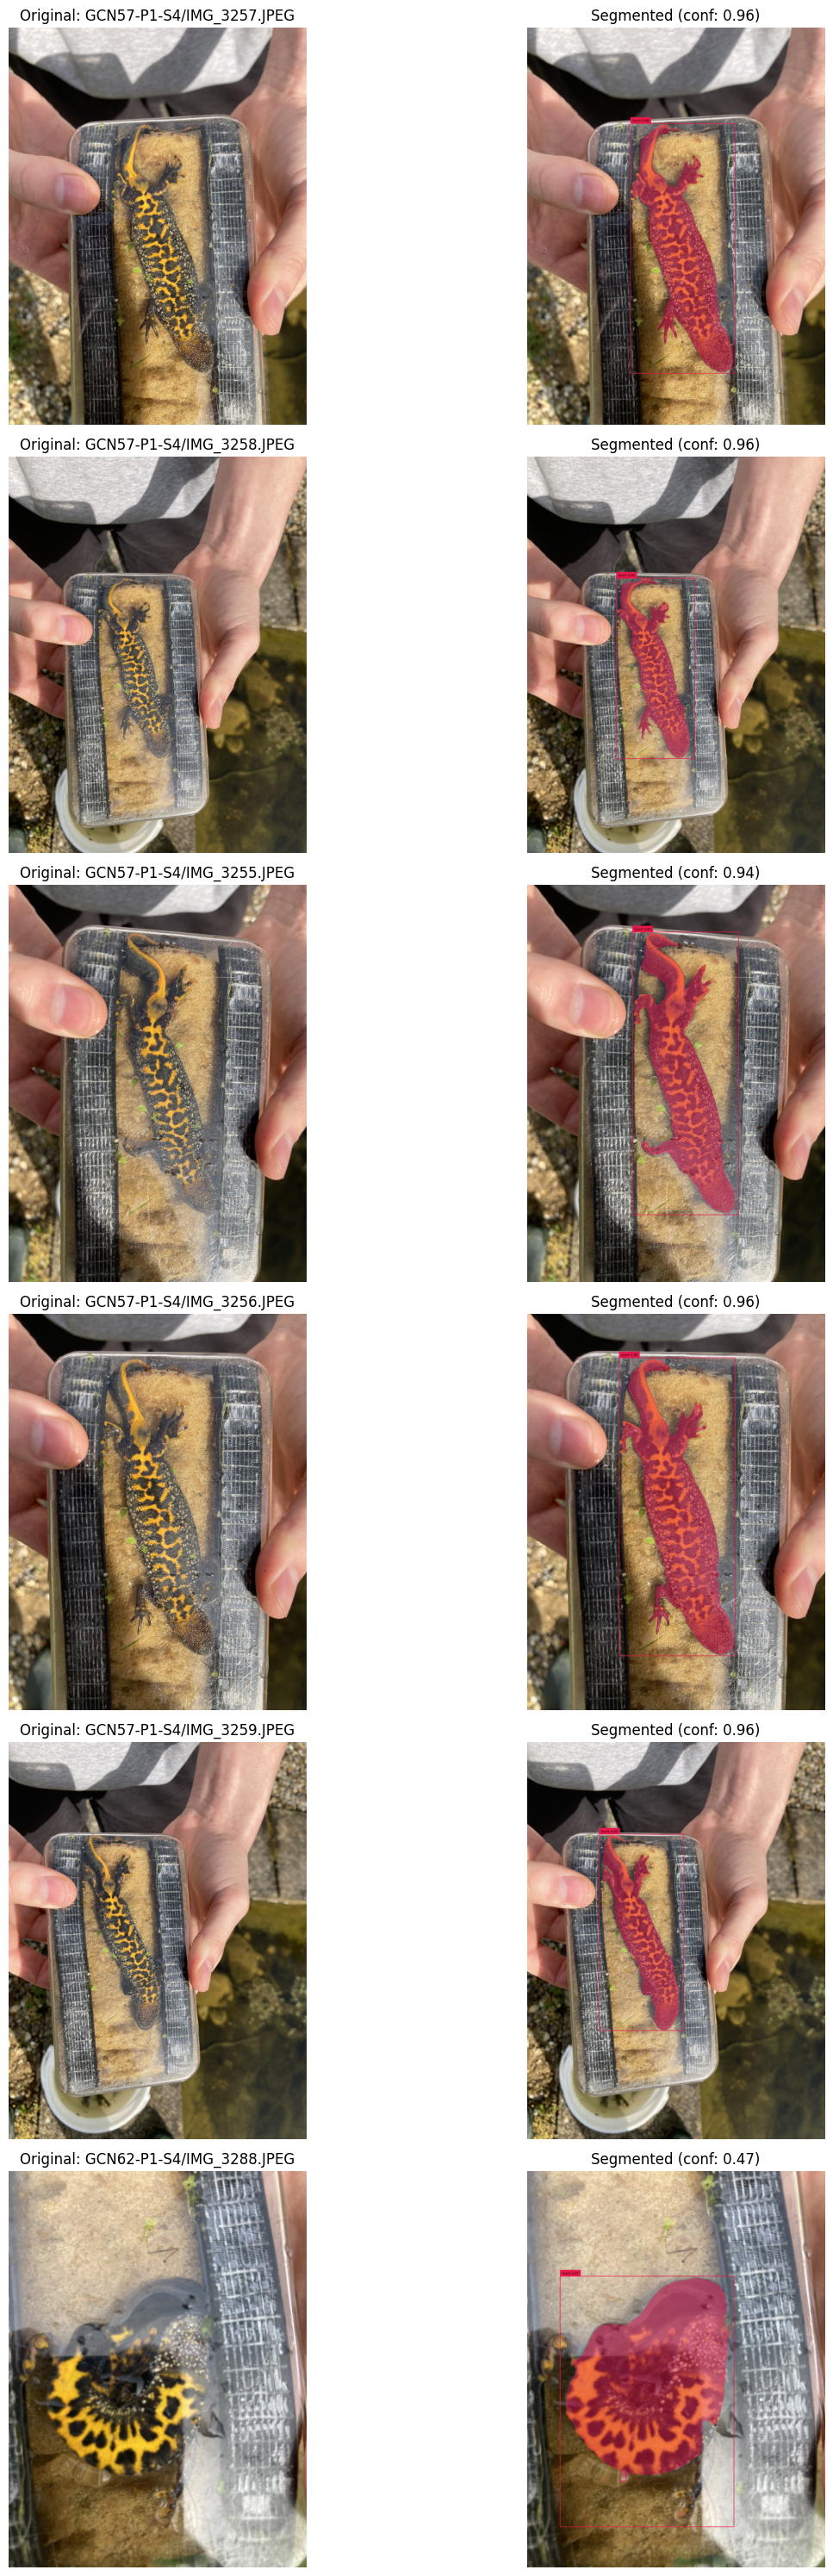

In [49]:
#| export
def visualize_segmentation(image_path, mask, bbox, label):
    import cv2
    import numpy as np
    import supervision as sv
    from utils.supervision_utils import CUSTOM_COLOR_MAP
    import matplotlib.pyplot as plt
    
    img = cv2.imread(image_path)
    detections = sv.Detections(
        xyxy=np.array(bbox).reshape(1, 4),
        mask=mask.astype(bool),
        class_id=np.array([0])
    )

    mask_annotator = sv.MaskAnnotator(color=sv.ColorPalette.from_hex(CUSTOM_COLOR_MAP))
    annotated_frame_final = mask_annotator.annotate(scene=img.copy(), detections=detections)

    if bbox is not None:
        box_annotator = sv.BoxAnnotator(color=sv.ColorPalette.from_hex(CUSTOM_COLOR_MAP))
        annotated_frame_boxes = box_annotator.annotate(scene=annotated_frame_final.copy(), detections=detections)
        
        label_annotator = sv.LabelAnnotator(color=sv.ColorPalette.from_hex(CUSTOM_COLOR_MAP), text_color=sv.Color.BLACK) # Specify text color if needed
        annotated_frame_labels = label_annotator.annotate(scene=annotated_frame_boxes.copy(), detections=detections, labels=[label])

        annotated_frame_final = mask_annotator.annotate(scene=annotated_frame_labels.copy(), detections=detections) # Use copy to avoid modifying annotated_frame_labels

    plt.imshow(cv2.cvtColor(annotated_frame_final, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [50]:
i = df[df.segmentation_mask_rle.notna()].index[0]
mask = decode_rle_mask(df.iloc[i].segmentation_mask_rle)
visualize_segmentation(data_path / df.iloc[i].file_path, mask.reshape(1, mask.shape[0], mask.shape[1]), df.iloc[i].bbox, "newt")

Updated metadata saved to ./data/barhill/gallery_and_probes_with_masks.csv
Added segmentation masks for 998 out of 1253 images


# Create sample visualisations

In [ ]:
os.makedirs(data_path / "sample_visualisations", exist_ok=True)

for i, row in tqdm(df[df.segmentation_mask_rle.notna()].sample(100).iterrows()):
    mask = decode_rle_mask(row.segmentation_mask_rle)
    mask = mask.reshape(1, mask.shape[0], mask.shape[1])
    
    plt.figure(figsize=(10, 10))
    visualize_segmentation(data_path / row.file_path, mask, row.bbox, "newt")
    plt.savefig(data_path / "sample_visualisations" / f"{row.identity}-{row.file_name}")
    plt.close()

# Create New Kaggle Dataset

metadata_dest = data_path / "metadata.csv"
df.to_csv(metadata_dest, index=False)

# Upload to Kaggle

In [ ]:
upload_to_kaggle(user_id="mshahoyi",
                title="GCNs Segmented", 
                id="newts-segmented-new", 
                licenses=[{"name": "CC0-1.0"}], 
                keywords=["biology", "computer-vision", "animals", "great crested newts"], 
                dataset_dir=data_path)

In [70]:
#| hide
import nbdev; nbdev.nbdev_export()


UPLOADING TO KAGGLE
Checking if dataset exists...


Current directory: /kaggle/working/gcn-reid/nbs/data/barhill-segmented
Files to upload: [Path('sample_segmentations'), Path('dataset-info.json'), Path('metadata.csv'), Path('README.md'), Path('original_images'), Path('dataset-metadata.json')]
Dataset exists, updating...
✅ Dataset updated successfully!
Output: Starting upload for file sample_segmentations.zip
Upload successful: sample_segmentations.zip (38MB)
Starting upload for file dataset-info.json
Upload successful: dataset-info.json (886B)
Starting upload for file metadata.csv
Upload successful: metadata.csv (6MB)
Starting upload for file README.md
Upload successful: README.md (2KB)
Starting upload for file original_images.zip
Upload successful: original_images.zip (804MB)
The following are not valid tags and could not be added to the dataset: ['computer-vision', 'newts']


Dataset available at: https://www.kaggle.com/datasets/mshahoyi/barhill-newts-segmented
